In [1]:
# Set the experiment name to be something meaningful. 
# It will be part of the name of the model to be saved.
EXPERIMENT_NAME = "[HashNet]"

In [2]:
from IPython.display import SVG

import tensorflow as tf
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Input, Concatenate, Layer
from keras.applications import vgg19
from keras.utils import plot_model
from keras.optimizers import RMSprop, Adam
from keras import backend as K
from keras.utils.vis_utils import model_to_dot

import sys
import datetime
import keras
import pickle
import logging
import h5py
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy import ndimage
import scipy.io

from songdb import data_dict
from preprocess import preprocess
from model import build_model

%matplotlib inline

/home/mjenrungrot/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
DEBUG = True
verbose = False
logger = logging.getLogger()

# File Handler
fhandler = logging.FileHandler(filename='HashNet.log', mode='w')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)

# Output stream Handler
ch = logging.StreamHandler(sys.stdout)
ch.setFormatter(formatter)
logger.addHandler(ch)

if DEBUG: 
    logger.setLevel(logging.DEBUG)
    ch.setLevel(logging.DEBUG)
else:     
    logger.setLeveL(logging.INFO)
    ch.setLevel(logging.INFO)

## Config Keras

In this code, we will use tensorflow backend on Keras because it's relatively faster than Theano. We'll use the image data format in the form of `(n_channel, width, height)`. Please look at the Keras documentation for more details.

In [4]:
assert K.backend() == 'tensorflow'
logger.debug("Keras backend is tensorflow.")

K.set_image_data_format('channels_first')
assert K.image_data_format() == 'channels_first'
logger.debug("Keras image data format is channels_first")

2018-03-04 23:25:39,471 - root - DEBUG - Keras backend is tensorflow.
2018-03-04 23:25:39,473 - root - DEBUG - Keras image data format is channels_first


## Load dataset
We load the pair-annotation dataset. `pairedData` is the dataset of shape `(number_of_pairs, 2, 76, 121)`.

In [5]:
logger.debug("Load Paired-annotation data")
data = data_dict()
logger.debug("\t data.type = {:}".format(type(data)))
logger.debug("\t data = {:}".format(data))
ref_query_pairs = data['taylorswift']

pairedData = np.array([np.zeros((2, 76, 121))])
for ref, query in ref_query_pairs:
    for i in range(ref.shape[0]):
        refQ = preprocess(librosa.cqt(np.asfarray(ref[i], dtype='float32'), sr = 22050, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96), 3).T
        queryQ = preprocess(librosa.cqt(np.asfarray(query[i], dtype='float32'), sr = 22050, fmin=130.81, n_bins=121, bins_per_octave=24, hop_length=96), 3).T
        Q = np.append(np.array([refQ]), np.array([queryQ]), axis=0)
        pairedData = np.append(pairedData, np.array([Q]), axis=0)
    logger.debug("Finish ref.shape = {:}; query.shape = {:}".format(ref, query))
    logger.debug("pairedData.shape = {:}".format(pairedData.shape))

pairedData = pairedData[1:]
print(pairedData.shape)
logger.debug("Finish loading paired-annotation data")
logger.debug("=> There are {:} pairs of shape ({:},{:})".format(pairedData.shape[0], pairedData.shape[2], pairedData.shape[3]))

2018-03-04 23:25:39,527 - root - DEBUG - Load Paired-annotation data
2018-03-04 23:25:39,528 - root - DEBUG - 	 data.type = <class 'dict'>
2018-03-04 23:25:39,529 - root - DEBUG - 	 data = {'taylorswift': <generator object get_ref_query_pairs at 0x7fbafe845888>}


/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):
/home/mjenrungrot/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.d

2018-03-04 23:26:01,654 - root - DEBUG - Finish ref.shape = [[    0     0     0 ...  1565  1927  2161]
 [-8822 -7639 -5306 ... -1938 -1163  -508]
 [ 6501  7379  7117 ... -3154 -3631 -4131]
 ...
 [-3321 -3112  1536 ...   358  -210   -17]
 [-4061 -4671 -5493 ...  2165  1801  1558]
 [ 1113  1304  1119 ...   489   614   483]]; query.shape = [[-2272 -1323    91 ...  3518  3913  3962]
 [ 2157  2058  2125 ...  1892  2977  3573]
 [  536   824   422 ...  2014  2054  2173]
 ...
 [ 2369  1726  -142 ...   689   746   671]
 [ 1684   673  1043 ...    82 -1499  -588]
 [ -350  -551  -903 ...  1930 -2946  2019]]
2018-03-04 23:26:01,656 - root - DEBUG - pairedData.shape = (273, 2, 76, 121)
2018-03-04 23:26:26,853 - root - DEBUG - Finish ref.shape = [[  982    -8 -1733 ...  5221  5406  5750]
 [ 4853  4249  3595 ... -2855 -3029 -3431]
 [ 3264  3743  4408 ...  4153  4774  4528]
 ...
 [-3321 -3112  1536 ...   358  -210   -17]
 [-4061 -4671 -5493 ...  2165  1801  1558]
 [ 1113  1304  1119 ...   489   614   4

## Preprocessing
Obtain a matrix $X_1$, $X_2$, $[w_{ij}]$, and $[s_{ij}]$ where $X_1$ and $X_2$ are pairs of images of shape 
`(n_samples, 1, width, height)`; $[w_{ij}]$ is the weight vector of shape `(n_samples, 1)` which describes the weight of each pair; and $[s_{ij}]$ is a binary vector of shape `(n_samples,1)` indicating whether inputs $i$ and $j$ are the same .

In [6]:
nPairs = pairedData.shape[0] 
X1 = []
X2 = []
S = []
groundTruth = []

__Add similar pairs__

We add similar pairs based on the dataset we have.

In [7]:
for idx in range(nPairs):
    X1.append(np.expand_dims(pairedData[idx][0][:][:], axis=0))
    X2.append(np.expand_dims(pairedData[idx][1][:][:], axis=0))
    groundTruth.append((idx,idx))
    S.append(True)

__Add non-similar pairs__

We add non-similar pairs by randomly selecting two CQT frames from the dataset. Note that we say two CQT pairs are not similar when they come from different indices. Specifically, `pairedData[idx1][0][:][:]` and `pairedData[idx2][1][:][:]` where `idx1 != idx2`.

In [8]:
nNonSimilar = 1000
for i in range(nNonSimilar):
    idx1 = np.random.randint(0, nPairs)
    idx2 = np.random.randint(0, nPairs)
    
    # Two randomly selected indices have to be different
    if idx1 == idx2: continue
        
    X1.append(np.expand_dims(pairedData[idx1][0][:][:], axis=0))
    X2.append(np.expand_dims(pairedData[idx2][1][:][:], axis=0))
    S.append(idx1 == idx2)
    groundTruth.append((idx1,idx2))

__Data Post-processing__

Convert $X_1$, $X_2$, $[s_{ij}]$ in to numpy arrays.

In [9]:
X1 = np.array(X1)
X2 = np.array(X2)
S = np.array(S).reshape(-1,1)

Calculate the weight vector $[w_{ij}]$. The term $w_{ij}$ is defined as 

$$
    w_{ij} = \begin{cases}
    \frac{|S|}{|S_{1}|} &\text{if $x^{(i)}$ is similar to $x^{(j)}$}\\
    \frac{|S|}{|S_{0}|} &\text{if $x^{(i)}$ is not similar to $x^{(j)}$}
    \end{cases}
$$

In [10]:
n_sim = len(S[S==True])
w_sim   = len(X1) / n_sim             # w_ij for similar pairs
w_insim = len(X1) / (len(X1) - n_sim)  # w_ij for dissimilar pairs
W = S*w_sim + (~S)*w_insim          # w vector for pairs

In [11]:
S = S.astype('float32')

Output some statistics and matrix shape.

In [12]:
logger.debug("X1 shape: {:}".format(X1.shape))
logger.debug("X2 shape: {:}".format(X2.shape))
logger.debug("S shape: {:}".format(S.shape))
logger.debug("W shape: {:}".format(W.shape))
logger.debug("There are {:} out of {:} pairs that are similar".format(n_sim, len(X1)))

2018-03-04 23:26:48,344 - root - DEBUG - X1 shape: (1733, 1, 76, 121)
2018-03-04 23:26:48,346 - root - DEBUG - X2 shape: (1733, 1, 76, 121)
2018-03-04 23:26:48,347 - root - DEBUG - S shape: (1733, 1)
2018-03-04 23:26:48,348 - root - DEBUG - W shape: (1733, 1)
2018-03-04 23:26:48,349 - root - DEBUG - There are 736 out of 1733 pairs that are similar


## Save Inputs

We save inputs to pickle files.

In [13]:
INPUT_NAME = str(datetime.date.today()) + EXPERIMENT_NAME + "X1"
with open(INPUT_NAME + ".pkl", "wb") as f:
    pickle.dump(X1, f, pickle.HIGHEST_PROTOCOL)
    logger.debug("Save X1 to {:}".format(INPUT_NAME + ".pkl"))

INPUT_NAME = str(datetime.date.today()) + EXPERIMENT_NAME + "X2"
with open(INPUT_NAME + ".pkl", "wb") as f:
    pickle.dump(X2, f, pickle.HIGHEST_PROTOCOL)
    logger.debug("Save X2 to {:}".format(INPUT_NAME + ".pkl"))

INPUT_NAME = str(datetime.date.today()) + EXPERIMENT_NAME + "S"
with open(INPUT_NAME + ".pkl", "wb") as f:
    pickle.dump(S, f, pickle.HIGHEST_PROTOCOL)
    logger.debug("Save S to {:}".format(INPUT_NAME + ".pkl"))

INPUT_NAME = str(datetime.date.today()) + EXPERIMENT_NAME + "W"
with open(INPUT_NAME + ".pkl", "wb") as f:
    pickle.dump(X1, f, pickle.HIGHEST_PROTOCOL)
    logger.debug("Save W to {:}".format(INPUT_NAME + ".pkl"))

2018-03-04 23:26:48,612 - root - DEBUG - Save X1 to 2018-03-04[HashNet]X1.pkl
2018-03-04 23:26:48,893 - root - DEBUG - Save X2 to 2018-03-04[HashNet]X2.pkl
2018-03-04 23:26:48,921 - root - DEBUG - Save S to 2018-03-04[HashNet]S.pkl
2018-03-04 23:26:49,173 - root - DEBUG - Save W to 2018-03-04[HashNet]W.pkl


## Model

__Define inputs__

Create a HashNet model with four inputs: two images tensors, similarity vector, and weight vector.

In [14]:
width = 76
height = 121
n_channel = 1

In [15]:
image_a    = Input(shape=(n_channel, width, height), name='image_1')
image_b    = Input(shape=(n_channel, width, height), name='image_2')
similarity = Input(shape=(1,), name="similarity")
weight     = Input(shape=(1,), name="weight")

__Pre-trained model__

Use a pre-trained model here to obtain intermediate values from the pre-trained model. We call this pre-trained model by `base_model`. The `base_model` is generally used to convert a CQT image to some representation.

In [16]:
model_path = '/data1/mint/public/taylorswift_out/model.mat'
model = scipy.io.loadmat(model_path)
logger.debug("Load model from {:}".format(model_path))
evecs = np.array(model['eigvecs']).T

2018-03-04 23:26:49,993 - root - DEBUG - Load model from /data1/mint/public/taylorswift_out/model.mat


In [17]:
m = 20
pca_matrix = np.array([vec.reshape((m, -1)) for vec in evecs])
delta = 4
base_model = build_model(pca_matrix, refQ.shape, delta=delta, COMPUTE_DELTA=True)
logger.debug("Construct base model")

2018-03-04 23:26:52,902 - root - DEBUG - Construct base model


2018-03-04 23:26:53,090 - root - DEBUG - Save base_model architecture to base_model.png


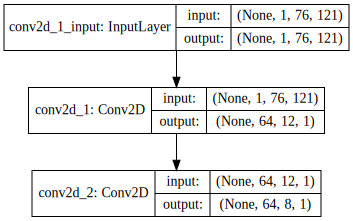

In [18]:
plot_model(base_model, show_shapes=True, to_file='base_model.png')
logger.debug("Save base_model architecture to base_model.png")
SVG(model_to_dot(base_model, show_shapes=True).create(prog='dot', format='svg'))

__Obtain intermediate values__

Intermediate values are values directly after the base model.

In [19]:
# Obtain intermediate tensor
intermediate_a = base_model(image_a)
intermediate_b = base_model(image_b)

# Flatten the layer
flatten_a = Flatten()(intermediate_a)
flatten_b = Flatten()(intermediate_b)

__Append a layer for binary encoding__

This layer has a `tanh` activation defined in the same way as HashNet paper. Note that initial beta value, number of bits, and `alpha` in the block below are hyperparameters.

In [20]:
beta         = 1            # Initial beta value
numberOfBits = 256
alpha        = 0.5
logger.debug("[HashNet Model] beta = {:}, numberOfBits = {:}, alpha = {:}".format(beta, numberOfBits, alpha))

2018-03-04 23:26:53,300 - root - DEBUG - [HashNet Model] beta = 1, numberOfBits = 256, alpha = 0.5


In [21]:
def custom_activation(x):
    """
    Our own defined activation function
    """
    global beta
    return K.tanh(beta * x)

In [22]:
class CustomizedLossLayer(Layer):
    """
    Our own defined layer for keeping track of loss function
    """
    
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomizedLossLayer, self).__init__(**kwargs)
    
    def my_loss(self, encoded_a, encoded_b, similarity, weight):
        global alpha
        x = encoded_a
        y = encoded_b
        dot_product = K.sum(x * y, axis=-1, keepdims=True)
        return K.sum(weight * (K.log(1 + K.exp(alpha * dot_product)) - alpha * similarity * dot_product))
    
    def call(self, inputs):
        encoded_a = inputs[0]
        encoded_b = inputs[1]
        similarity = inputs[2]
        weight = inputs[3]
        loss = self.my_loss(encoded_a, encoded_b, similarity, weight)
        self.add_loss(loss, inputs=inputs)
        return K.ones_like(similarity)


In [23]:
dense_layer = Dense(numberOfBits, activation=custom_activation)
encoded_a = dense_layer(flatten_a)
encoded_b = dense_layer(flatten_b)

__Create a model for training__

We construct a model using 2 representations derived by the same base model and similarity and weight. The architecture of the model is given below.

In [24]:
# Define a loss layer with 4 inputs
loss = CustomizedLossLayer()([encoded_a, encoded_b, similarity, weight])

In [25]:
# Define a model that has 4 inputs and outputs loss
model = Model(inputs=[image_a, image_b, similarity, weight], outputs=[loss])

In [26]:
# Compile the model with our own defined loss function.
# Note that loss function is already defined in a layer, so
# `zero_loss` here doesn't actually do anything.

def zero_loss(y_true, y_pred):
    return K.zeros_like(y_pred)

logger.debug("Use Adam optimizer with lr = 1e-5")
adam = Adam(lr=1e-5)
model.compile(optimizer=adam, loss=zero_loss)

2018-03-04 23:26:53,406 - root - DEBUG - Use Adam optimizer with lr = 1e-5


__Visualize model architecture__

2018-03-04 23:26:53,809 - root - DEBUG - Save model architecture to model.png


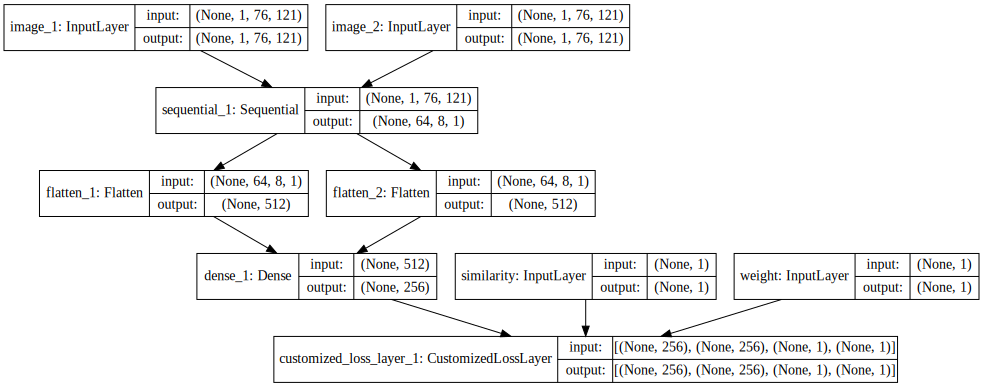

In [27]:
plot_model(model, show_shapes=True, to_file='model.png')
logger.debug("Save model architecture to model.png")
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Visualize performance before training

For the purpose of understanding the performance of this algorithm, we find the baseline result by computing the hamming distance between two representations before training and then plotting the corresponding histogram. Based on the above diagram, we use the representation at layers named `flatten_1` and `flatten_2`, before the fully connected layer defined by HashNet paper.

In [28]:
representation_model = Model(image_a, flatten_a)

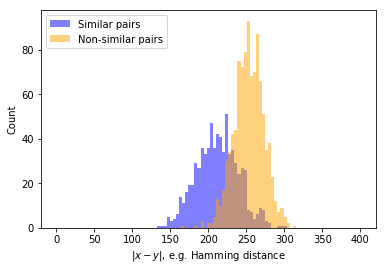

In [29]:
plt.figure()
hist_sim = []
hist_non_sim = []
bins = np.linspace(0, 400, 100)

pred_X1 = (representation_model.predict(X1) > 0)
pred_X2 = (representation_model.predict(X2) > 0)
for idx in range(len(X1)):
    score = np.count_nonzero(pred_X1[idx] != pred_X2[idx])
    similarity = (groundTruth[idx][0] == groundTruth[idx][1])
    
    if similarity:
        hist_sim.append(score)
    else:
        hist_non_sim.append(score)
        
plt.ylabel("Count")
plt.xlabel("$|x-y|$, e.g. Hamming distance")
plt.hist(hist_sim, bins, alpha=0.5, label='Similar pairs', color='blue')
plt.hist(hist_non_sim, bins, alpha=0.5, label='Non-similar pairs', color='orange')
plt.legend()
plt.show()

## Train a model

In [30]:
# Check the input shape
logger.debug("Ready to train the model")
logger.debug("X1 shape: {:}".format(X1.shape))
logger.debug("X2 shape: {:}".format(X2.shape))
logger.debug("S shape: {:}".format(S.shape))
logger.debug("W shape: {:}".format(W.shape))

2018-03-04 23:26:55,715 - root - DEBUG - Ready to train the model
2018-03-04 23:26:55,717 - root - DEBUG - X1 shape: (1733, 1, 76, 121)
2018-03-04 23:26:55,718 - root - DEBUG - X2 shape: (1733, 1, 76, 121)
2018-03-04 23:26:55,720 - root - DEBUG - S shape: (1733, 1)
2018-03-04 23:26:55,721 - root - DEBUG - W shape: (1733, 1)


In [31]:
number_of_iterations = 5
logger.debug("[Training] number_of_iterations = {:}".format(number_of_iterations))
beta_factor = 100
logger.debug("[Training] beta_factor = {:}".format(beta_factor))
number_of_epochs = 200
logger.debug("[Training] number_of_epochs = {:}".format(number_of_epochs))

2018-03-04 23:26:55,732 - root - DEBUG - [Training] number_of_iterations = 5
2018-03-04 23:26:55,734 - root - DEBUG - [Training] beta_factor = 100
2018-03-04 23:26:55,735 - root - DEBUG - [Training] number_of_epochs = 200


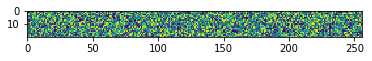

In [32]:
# Visualize the weight at the dense layer before training
plt.imshow(dense_layer.get_weights()[0][:20])

2018-03-04 23:26:55,922 - root - DEBUG - Iteration 1 (current beta = 1)
2018-03-04 23:28:29,559 - root - DEBUG - Save evaluation plot at iteration 1 to Hamming-Iteration-1.png


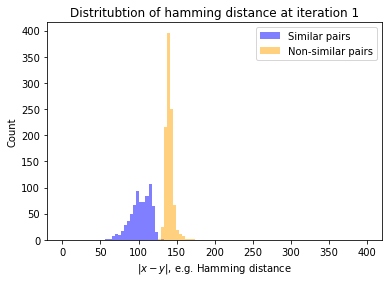

2018-03-04 23:28:29,941 - root - DEBUG - Iteration 2 (current beta = 100)
2018-03-04 23:30:05,784 - root - DEBUG - Save evaluation plot at iteration 2 to Hamming-Iteration-2.png


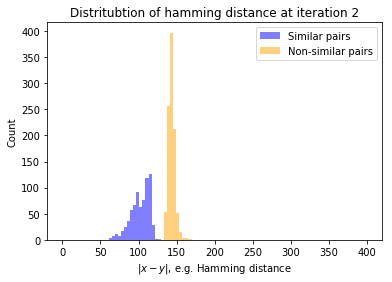

2018-03-04 23:30:06,159 - root - DEBUG - Iteration 3 (current beta = 10000)
2018-03-04 23:31:39,704 - root - DEBUG - Save evaluation plot at iteration 3 to Hamming-Iteration-3.png


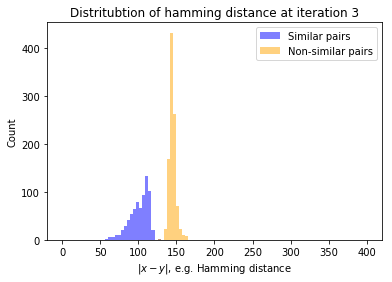

2018-03-04 23:31:40,061 - root - DEBUG - Iteration 4 (current beta = 1000000)
2018-03-04 23:33:11,988 - root - DEBUG - Save evaluation plot at iteration 4 to Hamming-Iteration-4.png


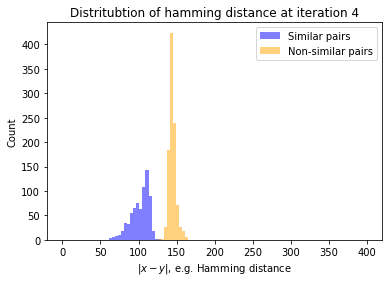

2018-03-04 23:33:12,351 - root - DEBUG - Iteration 5 (current beta = 100000000)
2018-03-04 23:34:44,994 - root - DEBUG - Save evaluation plot at iteration 5 to Hamming-Iteration-5.png


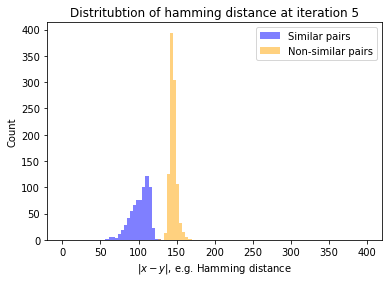

In [33]:
for m in range(1, number_of_iterations+1):
    logger.debug("Iteration {:} (current beta = {:})".format(m, beta))
    
    # Train a model with 4 inputs and 1 dummy output.
    model.fit({'image_1': X1, 'image_2': X2, 'similarity': S, 'weight': W}, [S], verbose=verbose, epochs=number_of_epochs)
    beta *= beta_factor
    
    plt.figure()
    hist_sim = []
    hist_non_sim = []
    bins = np.linspace(0, 400, 100)

    representation_model = Model(image_a, encoded_a)
    pred_X1 = (representation_model.predict(X1) > 0)
    pred_X2 = (representation_model.predict(X2) > 0)
    for idx in range(len(X1)):
        score = np.count_nonzero(pred_X1[idx] != pred_X2[idx])
        similarity = (groundTruth[idx][0] == groundTruth[idx][1])

        if similarity:
            hist_sim.append(score)
        else:
            hist_non_sim.append(score)

    plt.title("Distritubtion of hamming distance at iteration {:}".format(m))
    plt.ylabel("Count")
    plt.xlabel("$|x-y|$, e.g. Hamming distance")
    plt.hist(hist_sim, bins, alpha=0.5, label='Similar pairs', color='blue')
    plt.hist(hist_non_sim, bins, alpha=0.5, label='Non-similar pairs', color='orange')
    plt.legend()
    plt.savefig("Hamming-Iteration-{:}.png".format(m))
    logger.debug("Save evaluation plot at iteration {:} to Hamming-Iteration-{:}.png".format(m, m))
    plt.show()

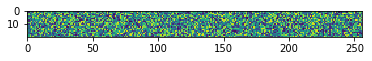

In [34]:
# Visualize the weight at the dense layer after training
plt.imshow(dense_layer.get_weights()[0][:20])

## Save Model

In [35]:
MODEL_NAME = str(datetime.date.today()) + EXPERIMENT_NAME + "[Iteration={:}]".format(number_of_iterations)
logger.debug("Save model to {:}.h5".format(MODEL_NAME))
model.save(MODEL_NAME + ".h5")

2018-03-04 23:34:45,715 - root - DEBUG - Save model to 2018-03-04[HashNet][Iteration=5].h5


## Visualize Performance 

__Obtain a representation model__

This representation model is the same as the trained model above without the loss layer at the very end.

In [36]:
representation_model = Model(image_a, encoded_a)

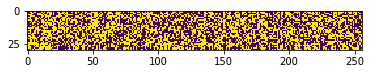

In [37]:
# Get sample output
pred_X1 = representation_model.predict(X1)
plt.imshow(pred_X1[:30] > 0)

## Evaluate Performance
Calculate the hamming distance input pairs and plot the corresponding histogram.

In [38]:
representation_model = Model(image_a, encoded_a)

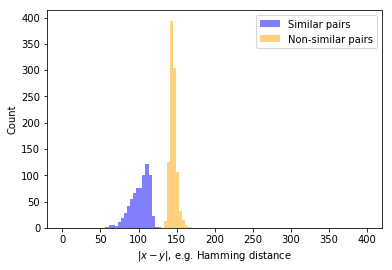

In [39]:
plt.figure()
hist_sim = []
hist_non_sim = []
bins = np.linspace(0, 400, 100)

pred_X1 = (representation_model.predict(X1) > 0)
pred_X2 = (representation_model.predict(X2) > 0)
for idx in range(len(X1)):
    score = np.count_nonzero(pred_X1[idx] != pred_X2[idx])
    similarity = (groundTruth[idx][0] == groundTruth[idx][1])
    
    if similarity:
        hist_sim.append(score)
    else:
        hist_non_sim.append(score)
        
plt.ylabel("Count")
plt.xlabel("$|x-y|$, e.g. Hamming distance")
plt.hist(hist_sim, bins, alpha=0.5, label='Similar pairs', color='blue')
plt.hist(hist_non_sim, bins, alpha=0.5, label='Non-similar pairs', color='orange')
plt.legend()
plt.show()